Basic volumerender.py

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from scipy.interpolate import interpn
import argparse
from scipy.interpolate import RegularGridInterpolator
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Pool

"""
Create Your Own Volume Rendering (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate the Schrodinger-Poisson system with the Spectral method
"""


def transfer_function(x):
    r = (
        1.0 * np.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * np.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.1 * np.exp(-((x - -3.0) ** 2) / 0.5)
    )
    g = (
        1.0 * np.exp(-((x - 9.0) ** 2) / 1.0)
        + 1.0 * np.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.1 * np.exp(-((x - -3.0) ** 2) / 0.5)
    )
    b = (
        0.1 * np.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * np.exp(-((x - 3.0) ** 2) / 0.1)
        + 1.0 * np.exp(-((x - -3.0) ** 2) / 0.5)
    )
    a = (
        0.6 * np.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * np.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.01 * np.exp(-((x - -3.0) ** 2) / 0.5)
    )
    return r, g, b, a


def transfer_function_optimized(x):
    temp1 = np.exp(-((x - 9.0) ** 2) / 1.0)
    temp2 = np.exp(-((x - 3.0) ** 2) / 0.1)
    temp3 = np.exp(-((x + 3.0) ** 2) / 0.5)
    r = 1.0 * temp1 + 0.1 * temp2 + 0.1 * temp3
    g = 1.0 * temp1 + 1.0 * temp2 + 0.1 * temp3
    b = 0.1 * temp1 + 0.1 * temp2 + 1.0 * temp3
    a = 0.6 * temp1 + 0.1 * temp2 + 0.01 * temp3
    return r, g, b, a


def render_angle(datacube, points, angle, n_angles, args, N=180):
    print("Rendering Scene " + str(angle + 1) + " of " + str(n_angles) + ".")

    angle = np.pi / 2 * angle / n_angles
    c = np.linspace(-N / 2, N / 2, N)
    qx, qy, qz = np.meshgrid(c, c, c)
    qx_r = qx
    qy_r = qy * np.cos(angle) - qz * np.sin(angle)
    qz_r = qy * np.sin(angle) + qz * np.cos(angle)
    qi = np.array([qx_r.ravel(), qy_r.ravel(), qz_r.ravel()]).T

    # Interpolate onto Camera Grid
    if args.interpolate_func == "scipy":
        camera_grid = interpn(points, datacube, qi, method="linear").reshape((N, N, N))
    elif args.interpolate_func == "scipy2":
        interpolator = RegularGridInterpolator(points, datacube, method="linear")
        camera_grid = interpolator(qi).reshape((N, N, N))
    else:
        raise ValueError("Unknown interpolation function")

    # Do Volume Rendering
    image = np.zeros((camera_grid.shape[1], camera_grid.shape[2], 3))

    for dataslice in camera_grid:
        # Use correct transfer function
        if args.transfer_func == "original":
            r, g, b, a = transfer_function(np.log(dataslice))
        elif args.transfer_func == "hand-optimized":
            r, g, b, a = transfer_function_optimized(np.log(dataslice))
        else:
            raise ValueError("Unknown transfer function")

        image[:, :, 0] = a * r + (1 - a) * image[:, :, 0]
        image[:, :, 1] = a * g + (1 - a) * image[:, :, 1]
        image[:, :, 2] = a * b + (1 - a) * image[:, :, 2]

    image = np.clip(image, 0.0, 1.0)

    if args.render:
        # Plot Volume Rendering
        plt.figure(figsize=(4, 4), dpi=80)

        plt.imshow(image)
        plt.axis("off")

        # Save figure
        plt.savefig(
            "img/volumerender" + str(angle) + ".png",
            dpi=240,
            bbox_inches="tight",
            pad_inches=0,
        )
    return image

def main(args):

    """Volume Rendering"""

    # Load Datacube
    f = h5.File("datacube.hdf5", "r")
    datacube = np.array(f["density"])
    output = []

    # Datacube Grid
    n_x, n_y, n_z = datacube.shape
    x = np.linspace(-n_x / 2, n_x / 2, n_x)
    y = np.linspace(-n_y / 2, n_y / 2, n_y)
    z = np.linspace(-n_z / 2, n_z / 2, n_z)
    points = (x, y, z)

    # Do Volume Rendering at Different Veiwing Angles
    n_angles = 10
    if args.parallel == "serial":
        print("Rendering in serial.")
        for i in range(n_angles):
            output.append(render_angle(datacube, points, i, n_angles, args, N=180))
    elif args.parallel == "concurrent-futures":
        print("Rendering in parallel using concurrent-futures.")
        with ProcessPoolExecutor(max_workers=args.num_workers) as executor:
            results = [executor.submit(render_angle, datacube, points, i, n_angles, args, N=180) for i in range(n_angles)]
            for result in results:
                output.append(result.result())
    elif args.parallel == "multiprocessing":
        print("Rendering in parallel using multiprocessing")
        with Pool(args.num_workers) as pool:
            results = [pool.apply_async(render_angle, (datacube, points, i, n_angles, args, 180)) for i in range(n_angles)]
            for result in results:
                output.append(result.get())

    if args.render:
        # Plot Simple Projection -- for Comparison
        plt.figure(figsize=(4, 4), dpi=80)

        plt.imshow(np.log(np.mean(datacube, 0)), cmap="viridis")
        plt.clim(-5, 5)
        plt.axis("off")

        # Save figure
        plt.savefig("img/projection.png", dpi=240, bbox_inches="tight", pad_inches=0)

    if args.plot:
        plt.show()

    return output

Volumerender.py - cupy adapted

In [29]:
import cupy as cp
import matplotlib.pyplot as plt
import h5py as h5
from cupyx.scipy.interpolate import interpn as interpn_cupy
import argparse
from scipy.interpolate import RegularGridInterpolator
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Pool

"""
Create Your Own Volume Rendering (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate the Schrodinger-Poisson system with the Spectral method
"""


def transfer_function_cupy(x):
    r = (
        1.0 * cp.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * cp.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.1 * cp.exp(-((x - -3.0) ** 2) / 0.5)
    )
    g = (
        1.0 * cp.exp(-((x - 9.0) ** 2) / 1.0)
        + 1.0 * cp.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.1 * cp.exp(-((x - -3.0) ** 2) / 0.5)
    )
    b = (
        0.1 * cp.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * cp.exp(-((x - 3.0) ** 2) / 0.1)
        + 1.0 * cp.exp(-((x - -3.0) ** 2) / 0.5)
    )
    a = (
        0.6 * cp.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * cp.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.01 * cp.exp(-((x - -3.0) ** 2) / 0.5)
    )
    return r, g, b, a


def transfer_function_optimized_cupy(x):
    temp1 = cp.exp(-((x - 9.0) ** 2) / 1.0)
    temp2 = cp.exp(-((x - 3.0) ** 2) / 0.1)
    temp3 = cp.exp(-((x + 3.0) ** 2) / 0.5)
    r = 1.0 * temp1 + 0.1 * temp2 + 0.1 * temp3
    g = 1.0 * temp1 + 1.0 * temp2 + 0.1 * temp3
    b = 0.1 * temp1 + 0.1 * temp2 + 1.0 * temp3
    a = 0.6 * temp1 + 0.1 * temp2 + 0.01 * temp3
    return r, g, b, a


def render_angle_cupy(datacube, points, angle, n_angles, args, N=180):
    print("Rendering Scene " + str(angle + 1) + " of " + str(n_angles) + ".")

    angle = cp.pi / 2 * angle / n_angles
    c = cp.linspace(-N / 2, N / 2, N)
    qx, qy, qz = cp.meshgrid(c, c, c)
    qx_r = qx
    qy_r = qy * cp.cos(angle) - qz * cp.sin(angle)
    qz_r = qy * cp.sin(angle) + qz * cp.cos(angle)
    qi = cp.array([qx_r.ravel(), qy_r.ravel(), qz_r.ravel()]).T

    # Interpolate onto Camera Grid
    if args.interpolate_func == "scipy":
        camera_grid = interpn_cupy(points, datacube, qi, method="linear").reshape((N, N, N))
    elif args.interpolate_func == "scipy2":
        interpolator = RegularGridInterpolator(points, datacube, method="linear")
        camera_grid = interpolator(qi).reshape((N, N, N))
    else:
        raise ValueError("Unknown interpolation function")

    # Do Volume Rendering
    image = cp.zeros((camera_grid.shape[1], camera_grid.shape[2], 3))

    for dataslice in camera_grid:
        # Use correct transfer function
        if args.transfer_func == "original":
            r, g, b, a = transfer_function_cupy(cp.log(dataslice))
        elif args.transfer_func == "hand-optimized":
            r, g, b, a = transfer_function_optimized_cupy(cp.log(dataslice))
        else:
            raise ValueError("Unknown transfer function")

        image[:, :, 0] = a * r + (1 - a) * image[:, :, 0]
        image[:, :, 1] = a * g + (1 - a) * image[:, :, 1]
        image[:, :, 2] = a * b + (1 - a) * image[:, :, 2]

    image = cp.clip(image, 0.0, 1.0)

    if args.render:
        # Plot Volume Rendering
        plt.figure(figsize=(4, 4), dpi=80)

        plt.imshow(image.get().astype('float32'))
        plt.axis("off")

        # Save figure
        plt.savefig(
            "img/volumerender" + str(angle) + ".png",
            dpi=240,
            bbox_inches="tight",
            pad_inches=0,
        )
    return image

def main_cupy(args):
    """Volume Rendering"""

    # Load Datacube
    f = h5.File("datacube.hdf5", "r")
    datacube = cp.array(f["density"])
    output = []

    # Datacube Grid
    n_x, n_y, n_z = datacube.shape
    x = cp.linspace(-n_x / 2, n_x / 2, n_x)
    y = cp.linspace(-n_y / 2, n_y / 2, n_y)
    z = cp.linspace(-n_z / 2, n_z / 2, n_z)
    points = (x, y, z)

    # Do Volume Rendering at Different Veiwing Angles
    n_angles = 10
    if args.parallel == "serial":
        print("Rendering in serial.")
        for i in range(n_angles):
            output.append(render_angle_cupy(datacube, points, i, n_angles, args, N=180))
    elif args.parallel == "concurrent-futures":
        print("Rendering in parallel using concurrent-futures.")
        with ProcessPoolExecutor(max_workers=args.num_workers) as executor:
            results = [executor.submit(render_angle_cupy, datacube, points, i, n_angles, args, N=180) for i in range(n_angles)]
            for result in results:
                output.append(result.result())
    elif args.parallel == "multiprocessing":
        print("Rendering in parallel using multiprocessing")
        with Pool(args.num_workers) as pool:
            results = [pool.apply_async(render_angle_cupy, (datacube, points, i, n_angles, args, 180)) for i in range(n_angles)]
            for result in results:
                output.append(result.get())

    if args.render:
        # Plot Simple Projection -- for Comparison
        plt.figure(figsize=(4, 4), dpi=80)

        plt.imshow(cp.log(cp.mean(datacube, 0)).get(), cmap="viridis")
        plt.clim(-5, 5)
        plt.axis("off")

        # Save figure
        plt.savefig("img/projection.png", dpi=240, bbox_inches="tight", pad_inches=0)

    if args.plot:
        plt.show()

    return output

Setting up arguments

In [30]:
import argparse

# Define a function to parse arguments interactively
def parse_arguments(render=""):
    parser = argparse.ArgumentParser(description="Volume Rendering Optimization")

    parser.add_argument(
        "--no-render",
        action="store_false",
        dest="render",
        help="Do not render the results into images",
    )
    parser.add_argument(
        "--no-plot",
        action="store_false",
        dest="plot",
        help="Do not plot the results"
    )
    parser.add_argument(
        "--transfer-function",
        default="original",
        choices=["original", "hand-optimized", "cython"],
        dest="transfer_func",
        help="Transfer function to use",
    )
    parser.add_argument(
        "--interpolate-function",
        default="scipy",
        choices=["scipy", "scipy2"],
        dest="interpolate_func",
        help="Interpolation function to use",
    )
    parser.add_argument(
        "--parallel",
        choices=["serial", "concurrent-futures", "multiprocessing"],
        dest="parallel",
        help="Use parallel processing",
    )
    parser.add_argument(
        "--num-workers",
        default=5,
        type=int,
        dest="num_workers",
        help="Number of workers to use in parallel processing",
    )

    parser.add_argument(
        "--cupy",
        action="store_false",
        dest="cupy",
        help="run the cupy version",
    )


    # Parse arguments
    args = parser.parse_args([])

    # Alternatively, you can provide default values here, e.g.,
    # args = parser.parse_args(["--no-render", "--num-workers", "4"])

    return args

# Call the function to parse arguments
args = parse_arguments()
args_v1 = parse_arguments()
args_v2 = parse_arguments()
args_v3 = parse_arguments()
args_v4 = parse_arguments()
args_v5 = parse_arguments()
args_v6 = parse_arguments()

Timer on CPU (from `perfbench.py`)

--------------------------------------------------
no cupy
Rendering in serial.
Rendering Scene 1 of 10.
Rendering Scene 2 of 10.
Rendering Scene 3 of 10.
Rendering Scene 4 of 10.
Rendering Scene 5 of 10.
Rendering Scene 6 of 10.
Rendering Scene 7 of 10.
Rendering Scene 8 of 10.
Rendering Scene 9 of 10.
Rendering Scene 10 of 10.
no cupy
Rendering in serial.
Rendering Scene 1 of 10.
Rendering Scene 2 of 10.
Rendering Scene 3 of 10.
Rendering Scene 4 of 10.
Rendering Scene 5 of 10.
Rendering Scene 6 of 10.
Rendering Scene 7 of 10.
Rendering Scene 8 of 10.
Rendering Scene 9 of 10.
Rendering Scene 10 of 10.
no cupy
Rendering in serial.
Rendering Scene 1 of 10.
Rendering Scene 2 of 10.
Rendering Scene 3 of 10.
Rendering Scene 4 of 10.
Rendering Scene 5 of 10.
Rendering Scene 6 of 10.
Rendering Scene 7 of 10.
Rendering Scene 8 of 10.
Rendering Scene 9 of 10.
Rendering Scene 10 of 10.
no cupy
Rendering in serial.
Rendering Scene 1 of 10.
Rendering Scene 2 of 10.
Rendering Scene 3 of 10.
Rende

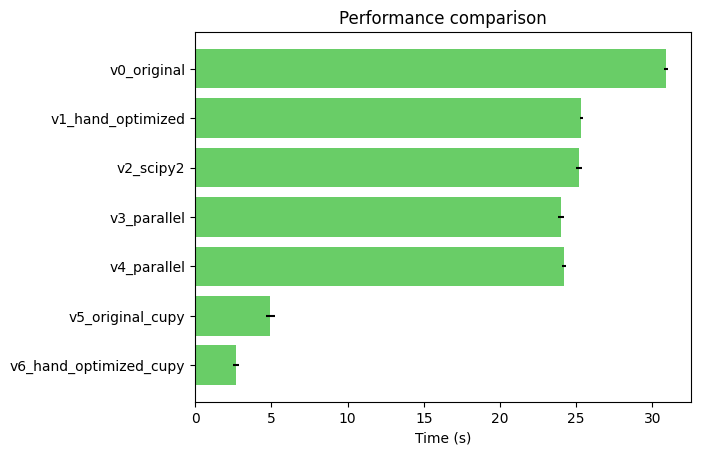

In [34]:
import argparse
import numpy as np
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt

"""
This is a performance benchmarking tool for the volumerender script.
It is used to compare the performance of the volumerender script with
the performance of the volumerender script after some optimization.

You can compare the performance of two (or more) versions of the script
or choose what optimization you want to use in the verions.

You can also compare all the versions of the script with the original
"""


def export_data(output, folder_name):
    basepath = "data/"
    if not os.path.exists(basepath + folder_name):
        os.makedirs(basepath + folder_name)
    for i in range(len(output)):
        np.save(basepath + folder_name + "/volumerender" + str(i) + ".npy", output[i])


# Function to compare data with the original version
def compare_data(optimized):
    originalpath = "data/original/"
    for i in range(len(optimized)):
        original = np.load(originalpath + "volumerender" + str(i) + ".npy")
        test = np.allclose(optimized[i], original)
        if not test:
            print("Data from the optimized version is not the same as the original")
            print("Original : ", original)
            print("Optimized : ", optimized[i])
        assert test


def time_function(fn, num_iters=1):
    def measure_time(*args, **kwargs):
        execution_times = np.empty((num_iters,))
        for i in range(num_iters):
            t1 = timer()
            outpt = fn(*args, **kwargs)
            t2 = timer()
            execution_times[i] = t2 - t1

        mean = np.mean(execution_times)
        std = np.std(execution_times)
        return mean, std, outpt

    return measure_time


def call_version(args_func):
    if(args_func.cupy) :
      print("cupy")
      return main_cupy(args_func)
    else :
      print("no cupy")
      return main(args_func)


def plot_all_version_comparison(*versions):
    # Plot the performance of all the versions as a horizontal bar chart
    # with the mean execution time and standard deviation
    version = []
    for name, args_ in versions:
        print("--------------------------------------------------")
        mean, std, out = time_function(call_version, num_iters=5)(args_)
        compare_data(out)
        version.append((name, mean, std))
        print("")

    # Now we plot the results
    _, ax = plt.subplots()
    y_pos = np.arange(len(version))
    names, means, stds = zip(*version)

    ax.barh(y_pos, means, xerr=stds, align="center", color="#69CD67", ecolor="black")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.set_xlabel("Time (s)")
    ax.set_title("Performance comparison")
    plt.show()


def just_time(*versions):
    for name, args in versions:
        mean, std, output = time_function(call_version)(args)
        compare_data(output)
        print(f"{name} : {mean}s +- {std}")

def parallel_workers_comparison(parallel: str, start: int, end: int):
    if parallel not in ["concurrent-futures", "multiprocessing"]:
        raise ValueError("parallel must be 'concurrent-futures' or 'multiprocessing'")
    versions = []
    for i in range(start, end + 1):
        versions.append(
            (
                f"v4_parallel_{i}_workers",
                argparse.Namespace(
                    render=False,
                    plot=False,
                    transfer_func="hand-optimized",
                    interpolate_func="scipy",
                    parallel=parallel,
                    num_workers=i,
                ),
            )
        )
    plot_all_version_comparison(*versions)


args.render = False
args.plot = False
args.transfer_func="original"
args.interpolate_func="scipy"
args.parallel = "serial"
args.cupy = False
v0_original = ( "v0_original", args,)


args_v1.render = False
args_v1.plot = False
args_v1.interpolate_func="scipy"
args_v1.parallel = "serial"
args_v1.transfer_func = "hand-optimized"
args_v1.cupy = False
v1_hand_optimized = ("v1_hand_optimized", args_v1,)

args_v2.render = False
args_v2.plot = False
args_v2.parallel = "serial"
args_v2.transfer_func = "hand-optimized"
args_v2.interpolate_func = "scipy2"
args_v2.cupy = False
v2_scipy2 = ("v2_scipy2", args_v2,)

args_v3.render = False
args_v3.plot = False
args_v3.transfer_func = "hand-optimized"
args_v3.interpolate_func = "scipy"
args_v3.parallel = "concurrent-futures"
args_v3.cupy = False
v3_parallel = ( "v3_parallel", args_v3,)

args_v4.render = False
args_v4.plot = False
args_v4.transfer_func = "hand-optimized"
args_v4.interpolate_func = "scipy"
args_v4.parallel = "multiprocessing"
args_v4.cupy = False
v4_parallel = ("v4_parallel",args_v4,)

args_v5.render = False
args_v5.plot = False
args_v5.transfer_func="original"
args_v5.interpolate_func="scipy"
args_v5.parallel = "serial"
args_v5.cupy = True
v5_original_cupy = ( "v5_original_cupy", args_v5,)

args_v6.render = False
args_v6.plot = False
args_v6.interpolate_func="scipy"
args_v6.parallel = "serial"
args_v6.transfer_func = "hand-optimized"
args_v6.cupy = True
v6_hand_optimized_cupy = ("v6_hand_optimized_cupy", args_v6,)


# Plot all the versions
plot_all_version_comparison(v0_original, v1_hand_optimized, v2_scipy2, v3_parallel, v4_parallel, v5_original_cupy, v6_hand_optimized_cupy)
